# Network IOP and Acceleration

The Network IO Processor (IOP) enables raw access to the Ethernet interface from within Python.
The usage is similar in many ways to sending and receiving Ethernet frames using raw sockets.

The advantages of this access include:
1. Packets can be sent with low-latency, bypassing the normal Linux kernel stack.
2. Access to the network interface is memory-mapped, enabling network-connected accelerators
   to be prototyped on the ARM cores and then migrated into the Programmable Logic (PL).


## 1. Downloading overlay
Now let's download the overlay and do necessary configurations.

In [1]:
from pynq.overlays.mqttsn import MqttsnOverlay

overlay = MqttsnOverlay("mqttsn.bit")
overlay.download()

In [2]:
import timeit
import logging
logging.getLogger("scapy.runtime").setLevel(logging.ERROR)
from scapy.all import *
from wurlitzer import sys_pipes
from broker_client.network_iop import NetworkIOP
from broker_client.slurper import PacketSlurper
from broker_client.pynqsocket import L2PynqSocket

conf.L2PynqSocket = L2PynqSocket

In [3]:
import sys
print(sys.path)

['', '/opt/python3.6/lib/python36.zip', '/opt/python3.6/lib/python3.6', '/opt/python3.6/lib/python3.6/lib-dynload', '/opt/python3.6/lib/python3.6/site-packages', '/opt/python3.6/lib/python3.6/site-packages/Twisted-17.9.1.dev0-py3.6-linux-armv7l.egg', '/opt/python3.6/lib/python3.6/site-packages/IPython/extensions', '/root/.ipython']


## 3. Bring up interfaces and modules
We can bring up a network interface for testing. 
For hardware acceleration, we need to inject the Linux kernel driver.

In [5]:
!chmod 777 ./kernel_module/*.sh
!ifconfig br0:1 192.168.3.99
!ifconfig br0:0 192.168.1.99

Bring up the kernel driver. This only needs to be run 1 time after the 
board has been booted.

In [6]:
!./kernel_module/link_up.sh

In [8]:
mynet = NetworkIOP()
conf.L2PynqSocket().flush()

185 packets flushed


## 4. Measuring performance
We can do a bit of research here. Let's find out how fast we can push out 
packets first, as shown below.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import PL
from pynq import MMIO
from broker_client import *

sizes = [64, 128, 256, 512, 1024, 1500]
count = 500
pps = []
bps = []
usperpacket = []
cyclesperword = []
theoretical = []
mmio = MMIO(0xFFFC0000, 0x10000)

my_ip_str = '192.168.1.104'
my_mac_str = '8a:70:bd:29:2b:40'

for size in sizes:
    payload = b''.join([b'0' for _ in range(size)])
    frame = Ether(src=my_mac_str, dst='FF:FF:FF:FF:FF:FF')/\
        IP(src=my_ip_str, dst="192.168.1.2")/\
        UDP(sport=50000, dport=1884)/MQTTSN()/MQTTSN_CONNECT()
    frame = bytes(frame) + payload
    slurper = conf.L2PynqSocket().slurper
    scapySocket = conf.L2socket()
    write32 = slurper.write32
    array = slurper.mmio.array
    mem = slurper.mmio.mem
    leng = len(frame)

    start_time = timeit.default_timer()
    for _ in range(count):
        frame_bytes = bytes(frame)
        slurper.send(frame_bytes)
    elapsed = timeit.default_timer() - start_time

    bps.append(count*len(frame)*8/elapsed)
    pps.append(count/elapsed)
    usperpacket.append(1000000/(count/elapsed))
    cyclesperword.append((100000000*elapsed)/(count*(len(frame)/4)))
    theoretical.append(100000000/(len(frame)/4))

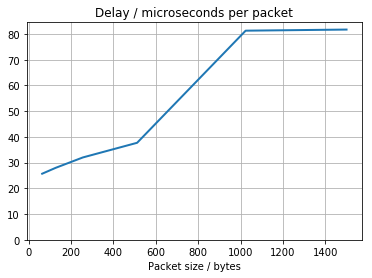

In [11]:
plt.title("Delay / microseconds per packet")
plt.plot(sizes, usperpacket, linewidth=2.0)
plt.ylim(ymin=0)
plt.xlabel('Packet size / bytes')
plt.grid(True)
plt.show()

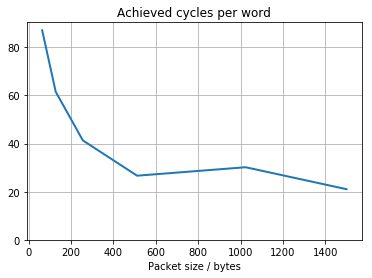

In [12]:
plt.title("Achieved cycles per word")
plt.plot(sizes, cyclesperword, linewidth=2.0)
plt.ylim(ymin=0)
plt.xlabel('Packet size / bytes')
plt.grid(True)
plt.show()

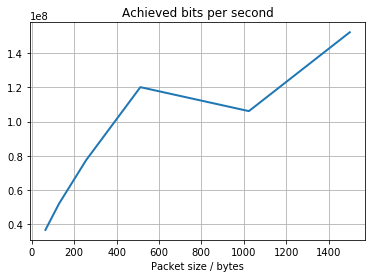

In [13]:
plt.title("Achieved bits per second")
plt.plot(sizes, bps, linewidth=2.0)
plt.xlabel('Packet size / bytes')
plt.grid(True)
plt.show()

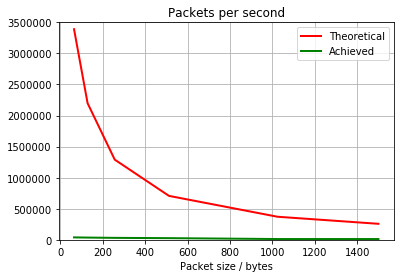

In [14]:
plt.title("Packets per second")
plot0, = plt.plot(sizes, theoretical, label='Theoretical',
                  linewidth=2.0, color='red')
plot1, = plt.plot(sizes, pps, label='Achieved', 
                  linewidth=2.0, color='green')
plt.legend(handles=[plot0, plot1])
plt.ylim(ymin=0, ymax=3500000)
plt.xlabel('Packet size / bytes')
plt.grid(True)
plt.show()

## 5. Cleanup
We can remove the kernel module and close the broker in the end.

In [16]:
!./kernel_module/link_down.sh 2>/dev/null
broker_mqtt.close()